In [1]:
# Using SVD to perform regualrisation when reconstructing our CST data

import numpy as np
import os

data_dir: str = "/mnt/d/samyap/lircst/analytical-simulation-aapm-idx25"

def load_random_sino(data_dir: str, dir_name: str | None=None, slice_idx: int | None=None) -> tuple[np.ndarray, np.ndarray, str]:
    """Load a random sinogram from the dataset directory."""

    dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
    
    # Get all files within a directory
    def get_files_in_dir(dir_name):
        return [f for f in os.listdir(os.path.join(data_dir, dir_name)) if os.path.isfile(os.path.join(data_dir, dir_name, f))]

    # Select a random directory
    dir_name = np.random.choice(dirs) if dir_name is None else dir_name
    files = get_files_in_dir(dir_name)
    sino_file_name = np.random.choice([f for f in files if f.startswith('sino')]) if slice_idx is None else f"sino-{slice_idx}.npy"
    phan_file_name = f"phan-{sino_file_name.split("-")[1].split(".")[0]}.npy"

    phan = np.load(os.path.join(data_dir, dir_name, phan_file_name))
    sino = np.load(os.path.join(data_dir, dir_name, sino_file_name))

    identifier: str = f"{dir_name}-{sino_file_name.replace('.npy', '').replace('sino-', '')}"

    return sino, phan, identifier




Shape of A: (25600, 16384)


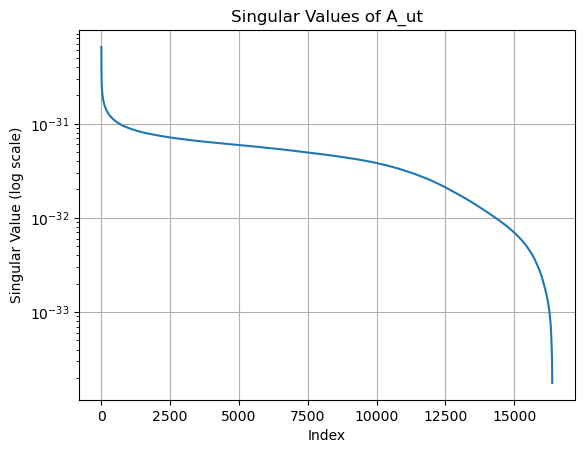

In [2]:
# Load the operator matrix A, which we will then decompose using SVD

operator_dir: str = "../data_discretised/"

A: np.ndarray = np.load(os.path.join(operator_dir, "A_ut.npy")) # Remember, this is the discretised operator matrix which only considers the scattering component of our simulation, and only regards itself with the detector x theta dimensions (no bins)

print(f"Shape of A: {A.shape}")

import torch
# Convert A to a torch tensor
A_torch = torch.from_numpy(A).float()
# Perform SVD
'''
U, S, Vh = torch.linalg.svd(A_torch, full_matrices=False)
V: torch.Tensor = Vh.T
'''
# We have precomputed the SVD to save time
svd_dir: str = '../data_discretised/svd/'
U: torch.Tensor = torch.from_numpy(np.load(os.path.join(svd_dir, "A_ut_U.npy")))
S: torch.Tensor = torch.from_numpy(np.load(os.path.join(svd_dir, "A_ut_S.npy")))
V: torch.Tensor = torch.from_numpy(np.load(os.path.join(svd_dir, "A_ut_V.npy")))

import matplotlib.pyplot as plt
# Let's visualise the singular values
plt.figure()
plt.semilogy(S.numpy())
plt.title("Singular Values of A_ut")
plt.xlabel("Index")
plt.ylabel("Singular Value (log scale)")
plt.grid()
plt.show()


def compute_pseudoinverse(U: torch.Tensor, S: torch.Tensor, V: torch.Tensor, sigma_thresh: float) -> torch.Tensor:
    """Compute the pseudoinverse of A using SVD components with regularisation."""
    mask = (S >= sigma_thresh).float()
    S_inv = torch.zeros_like(S)
    S_inv[mask.bool()] = 1.0 / S[mask.bool()]

    # Compute pseudo-inverse regularised A_ut_reg_pinv
    A_ut_reg_pinv: torch.Tensor = V @ (S_inv.unsqueeze(1) * U.T)
    return A_ut_reg_pinv

sigma_thresh_values: list[float] = [S[i].item() for i in range(0, len(S), 1000)] + [0.0]



In [3]:
# Let's also have some quantitative metrics

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse

def losses(x_reconstructed: torch.Tensor, x_gt: torch.Tensor):
    x_reconstructed_np = x_reconstructed.cpu().numpy()
    x_gt_np = x_gt.cpu().numpy()

    # Normalise to [0, 1] range for fair comparison
    x_reconstructed_np = (x_reconstructed_np - x_reconstructed_np.min()) / (x_reconstructed_np.max() - x_reconstructed_np.min())
    x_gt_np = (x_gt_np - x_gt_np.min()) / (x_gt_np.max() - x_gt_np.min())

    psnr_value = psnr(x_gt_np, x_reconstructed_np, data_range=x_gt_np.max() - x_gt_np.min())
    ssim_value = ssim(x_gt_np, x_reconstructed_np, data_range=x_gt_np.max() - x_gt_np.min())
    rmse_value = np.sqrt(mse(x_gt_np, x_reconstructed_np))

    return psnr_value, ssim_value, rmse_value

In [4]:


def parameter_sweep(sino: np.ndarray,
                    phan: np.ndarray,
                    identifier: str,) -> tuple[str, dict[float, tuple[float, float, float]], dict[float, np.ndarray]]:
    # Convert to torch tensors
    sino = torch.from_numpy(sino).float()
    sino = torch.sum(sino, axis=-1) # Sum over energy bins
    phan = torch.from_numpy(phan).float()

    results = {}
    reconstructions_for_figs: dict[float, np.ndarray] = {}

    # Also perform a no regularisation reconstruction (pure back-projection)
    x_reconstructed_bp = A_torch.T @ sino.ravel()
    x_reconstructed_bp = x_reconstructed_bp.reshape(phan[0].shape)
    psnr_value, ssim_value, rmse_value = losses(x_reconstructed_bp, phan[0])
    print(f"  No Regularisation (Back-Projection) | PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, RMSE: {rmse_value:.4f}")
    results[-1] = (psnr_value, ssim_value, rmse_value)
    reconstructions_for_figs[-1] = x_reconstructed_bp.cpu().numpy()


    for sigma_thresh_idx, sigma_thresh in enumerate(sigma_thresh_values):
        A_ut_reg_pinv = compute_pseudoinverse(U, S, V, sigma_thresh)

        # Reconstruct the phantom
        x_reconstructed = A_ut_reg_pinv @ sino.ravel()

        # Reshape to original phantom shape
        x_reconstructed = x_reconstructed.reshape(phan[0].shape)

        # Compute losses
        psnr_value, ssim_value, rmse_value = losses(x_reconstructed, phan[0])

        print(f"  Sigma_thresh: {sigma_thresh:.4e} | PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}, RMSE: {rmse_value:.4f}")

        results[sigma_thresh] = (psnr_value, ssim_value, rmse_value)

        # Store reconstruction for figure
        if reconstructions_for_figs is not None and sigma_thresh_idx % 2 == 0:
            reconstructions_for_figs[sigma_thresh] = x_reconstructed.cpu().numpy()



    return identifier, results, reconstructions_for_figs

output_dir: str = "../regularisation_test_output/"

In [ ]:
# Load (e.g.) a hundred random samples, and do a parameter sweep over sigma_thresh values for each one.
# Save the results for later plotting/analysis

num_samples: int = 100
results: dict[str, dict[float, tuple[float, float, float]]] = {}



run_identifier: str = f"{np.random.randint(0, 1e6):06d}"

for sample_idx in range(num_samples):
    sino_np, phan_np, identifier = load_random_sino(data_dir)
    print(f"Processing sample {sample_idx + 1}/{num_samples}: {identifier}")

    # Convert to torch tensors
    sino = torch.from_numpy(sino_np).float()
    sino = torch.sum(sino, axis=-1) # Sum over energy bins
    phan = torch.from_numpy(phan_np).float()

    results[identifier] = {}
    reconstructions_for_figs: dict[float, np.ndarray] | None = {} if sample_idx % 10 == 0 else None

    identifier, sample_results, sample_reconstructions = parameter_sweep(sino_np, phan_np, identifier)
    results[identifier] = sample_results
    if reconstructions_for_figs is not None:
        reconstructions_for_figs.update(sample_reconstructions)

    # Save results to disk    
    np.save(os.path.join(output_dir, f"regularisation_svd_results_{run_identifier}.npy"), results)
    if reconstructions_for_figs is not None:
        np.save(os.path.join(output_dir, f"reconstructions_{identifier}_figs.npy"), reconstructions_for_figs)



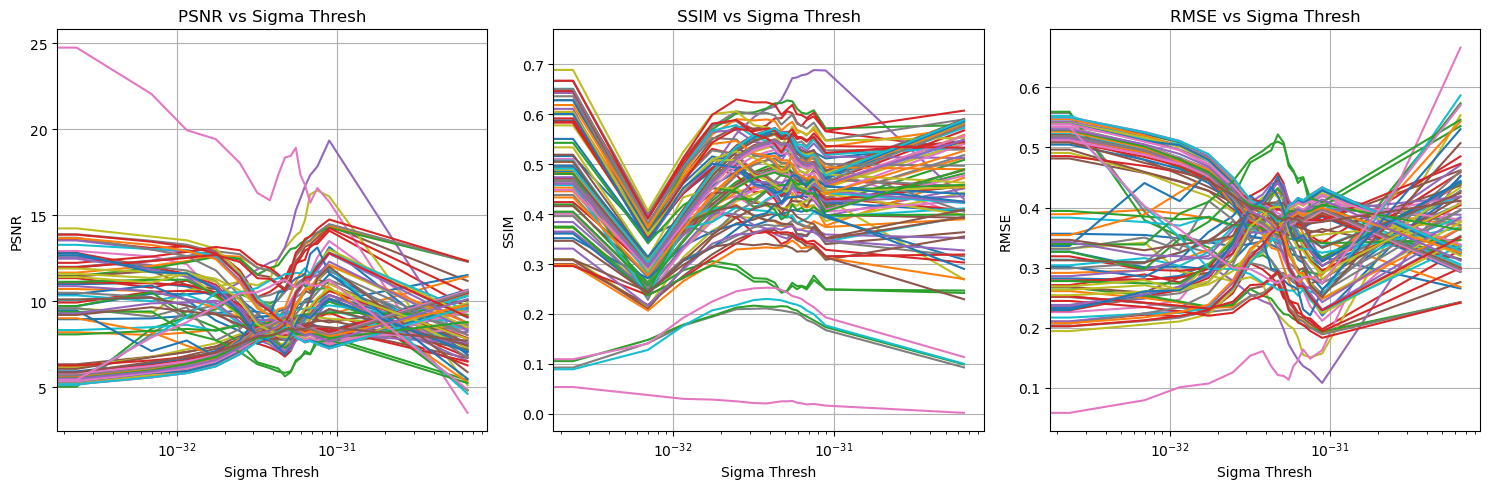

In [5]:
# Plot and visualise results

import matplotlib.pyplot as plt

# Load results from disk
results: dict[str, dict[float, tuple[float, float, float]]] = np.load(os.path.join(output_dir, "regularisation_svd_results.npy"), allow_pickle=True).item()

# Plot all samples' results on one figure, for PSNR, SSIM, RMSE vs sigma_thresh
plt.figure(figsize=(15, 5))

def plot_results(results: dict[str, dict[float, tuple[float, float, float]]]):
    for identifier, res in results.items():
        sigma_threshs = sorted(res.keys())
        psnr_values = [res[sigma][0] for sigma in sigma_threshs]
        ssim_values = [res[sigma][1] for sigma in sigma_threshs]
        rmse_values = [res[sigma][2] for sigma in sigma_threshs]


        plt.subplot(1, 3, 1)
        plt.semilogx(sigma_threshs, psnr_values, label=identifier)
        plt.xlabel("Sigma Thresh")
        plt.ylabel("PSNR")
        plt.title("PSNR vs Sigma Thresh")
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.semilogx(sigma_threshs, ssim_values, label=identifier)
        plt.xlabel("Sigma Thresh")
        plt.ylabel("SSIM")
        plt.title("SSIM vs Sigma Thresh")
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.semilogx(sigma_threshs, rmse_values, label=identifier)
        plt.xlabel("Sigma Thresh")
        plt.ylabel("RMSE")
        plt.title("RMSE vs Sigma Thresh")
        plt.grid()
    plt.tight_layout()
    plt.show()

plot_results(results)

In [ ]:
# Visualise the reconstructions for samples where we saved them
recon_files = [f for f in os.listdir(output_dir) if f.startswith("reconstructions_") and f.endswith("_figs.npy")]

def plot_figs(reconstructions_for_figs: dict[float, np.ndarray], identifier: str):
    num_recons = len(reconstructions_for_figs)
    plt.figure(figsize=(15, 5))
    for idx, (sigma_thresh, recon) in enumerate(reconstructions_for_figs.items()):
        plt.subplot(1, num_recons, idx + 1)
        plt.imshow(recon, cmap='gray')
        plt.title(f"Sigma Thresh: {sigma_thresh:.2e}")
        plt.axis('off')
    plt.suptitle(f"Reconstructions for {identifier}")
    plt.show()

for recon_file in recon_files:
    reconstructions_for_figs: dict[float, np.ndarray] = np.load(os.path.join(output_dir, recon_file), allow_pickle=True).item()
    identifier = recon_file.replace("reconstructions_", "").replace("_figs.npy", "")

    plot_figs(reconstructions_for_figs, identifier)

  No Regularisation (Back-Projection) | PSNR: 8.56, SSIM: 0.2344, RMSE: 0.3731
  Sigma_thresh: 6.5051e-31 | PSNR: 6.91, SSIM: 0.2073, RMSE: 0.4514
  Sigma_thresh: 8.9374e-32 | PSNR: 10.37, SSIM: 0.2273, RMSE: 0.3029
  Sigma_thresh: 7.5349e-32 | PSNR: 10.14, SSIM: 0.2466, RMSE: 0.3113
  Sigma_thresh: 6.8035e-32 | PSNR: 9.81, SSIM: 0.2466, RMSE: 0.3234
  Sigma_thresh: 6.3141e-32 | PSNR: 9.36, SSIM: 0.2469, RMSE: 0.3403
  Sigma_thresh: 5.9190e-32 | PSNR: 9.09, SSIM: 0.2486, RMSE: 0.3513
  Sigma_thresh: 5.5316e-32 | PSNR: 8.85, SSIM: 0.2527, RMSE: 0.3611
  Sigma_thresh: 5.1451e-32 | PSNR: 9.18, SSIM: 0.2562, RMSE: 0.3475
  Sigma_thresh: 4.7337e-32 | PSNR: 8.77, SSIM: 0.2542, RMSE: 0.3642
  Sigma_thresh: 4.3056e-32 | PSNR: 8.80, SSIM: 0.2542, RMSE: 0.3630
  Sigma_thresh: 3.8168e-32 | PSNR: 8.76, SSIM: 0.2515, RMSE: 0.3648
  Sigma_thresh: 3.1855e-32 | PSNR: 9.06, SSIM: 0.2522, RMSE: 0.3525
  Sigma_thresh: 2.4787e-32 | PSNR: 9.92, SSIM: 0.2477, RMSE: 0.3190
  Sigma_thresh: 1.7540e-32 | PSNR: 

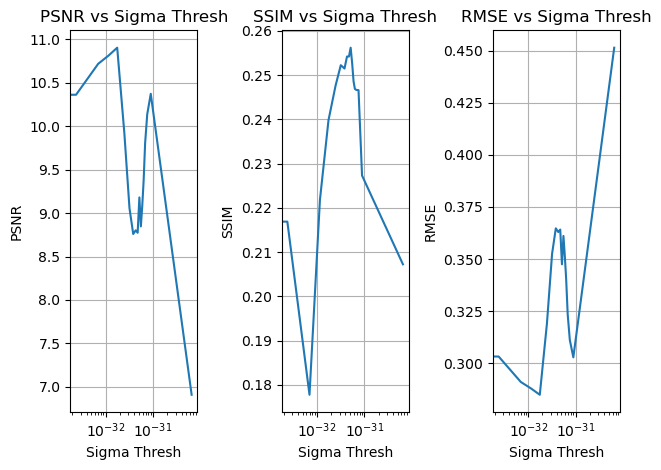

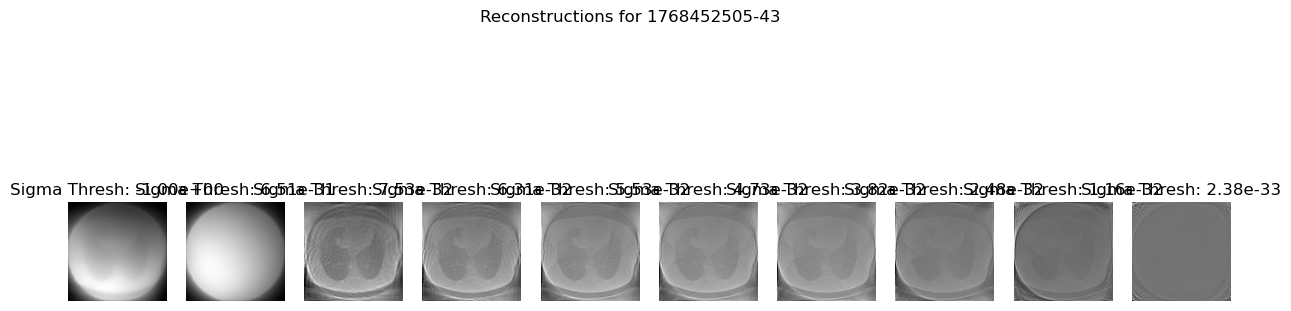

In [7]:
# Let's load some custom sample

#sino_np = np.load("/home/samnub/dev/lircst-iterecon/lircst_data_unseen/46290/sino-64.npy")
#phan_np = np.load("/home/samnub/dev/lircst-iterecon/lircst_data_unseen/46290/phan-64.npy")
#identifier = "46290-64"

sino_np, phan_np, identifier = load_random_sino(data_dir)

# Perform parameter sweep on this sample
identifier, sample_results, sample_reconstructions = parameter_sweep(sino_np, phan_np, identifier)

plot_results({identifier: sample_results})
plot_figs(sample_reconstructions, identifier)